In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # plotting

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
# Load dataset and review data structure
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data analysis

Examine data, build plots, search correlation between features.

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


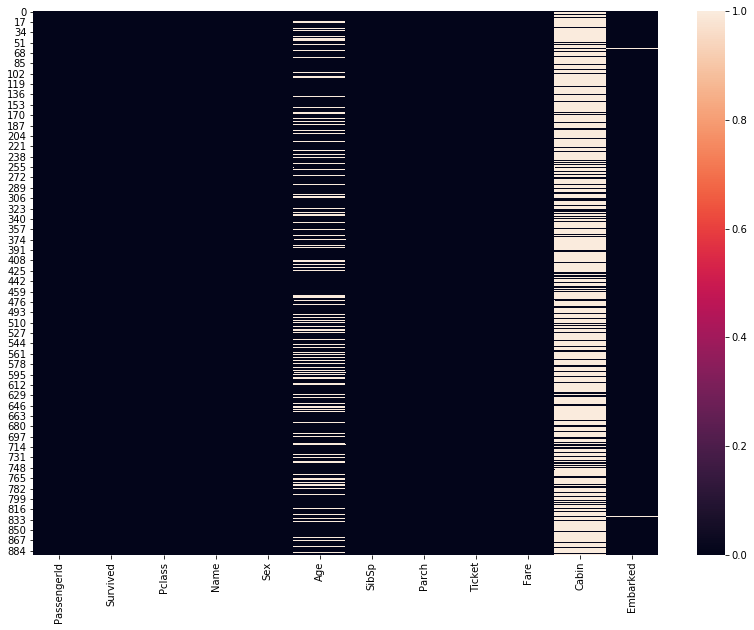

In [3]:
# Examine data misses
print(train_data.isnull().sum())
plt.figure(figsize=(14, 10))
sns.heatmap(train_data.isnull())

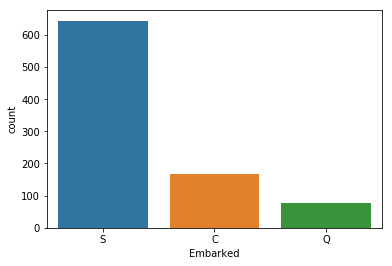

In [4]:
# Examine distribution of embarkation
sns.countplot(x='Embarked', data=train_data)

In [5]:
# There are only two missed values in 'Embarked' column.
# Due to distribution of embarkation we can fill missed values with mode.
# Note, that pd.Series.mode() always return a pd.Series object,
# so we should get first element
train_data.Embarked = train_data.Embarked.fillna(train_data.Embarked.mode()[0])

In [6]:
# Examine categorical data
train_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

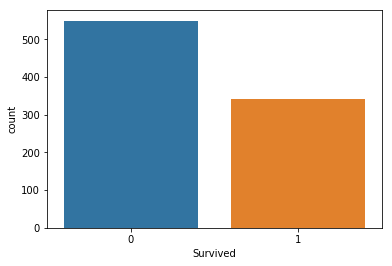

In [7]:
# Examine number of survived
sns.countplot(x='Survived', data=train_data)

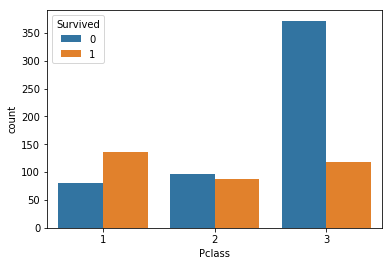

In [8]:
# Examine number of survived for each class
sns.countplot(x='Pclass', hue='Survived', data=train_data)

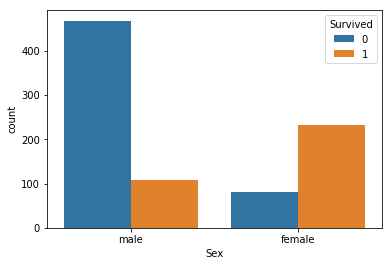

In [9]:
# Examine number of survived by sex
sns.countplot(x='Sex', hue='Survived', data=train_data)

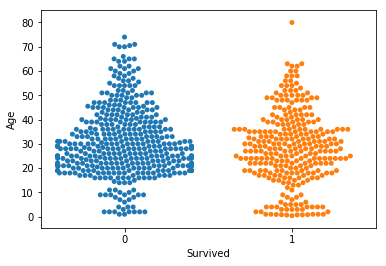

In [10]:
# Examine survived by age
sns.swarmplot(x='Survived', y='Age', data=train_data)

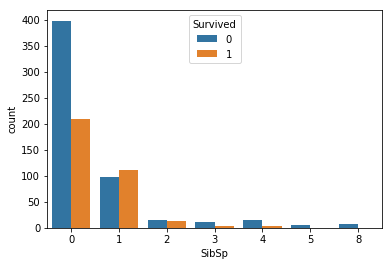

In [11]:
# Examine siblings-spouse influence
sns.countplot(x='SibSp', hue='Survived', data=train_data)

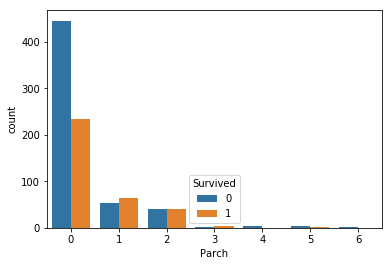

In [12]:
# Examine parents-children influence
sns.countplot(x='Parch', hue='Survived', data=train_data)

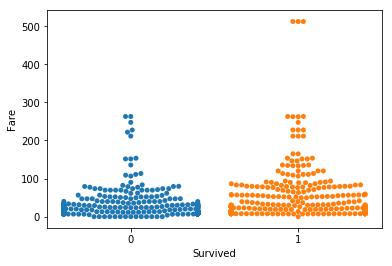

In [13]:
# Examine survived by fare
sns.swarmplot(x='Survived', y='Fare', data=train_data)

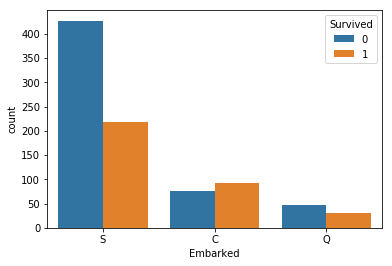

In [14]:
# Examine survived by port of embarkation
sns.countplot(x='Embarked', hue='Survived', data=train_data)

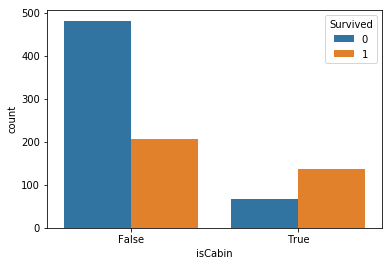

In [15]:
data_copy = train_data.copy()
data_copy['isCabin'] = train_data.Cabin.notna()
sns.countplot(x='isCabin', hue='Survived', data=data_copy)

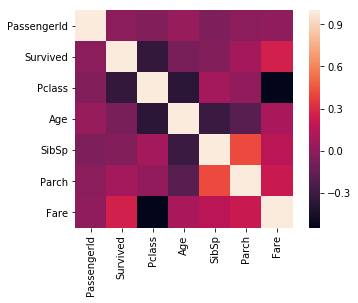

In [16]:
# Examine correlation between features
sns.heatmap(train_data.corr(), square=True)

In [17]:
# Fill missed values for 'Age' column
# We will use a passenger's name to identify his/her age group
# First of all, add a new feature called 'Title'
import re
def extract_title(name):
    return re.search(r'\w+(?=[.])', name).group(0)

train_data['Title'] = train_data.Name.map(extract_title)

# Examine titles with missed age
print(train_data.groupby('Title').apply(lambda x: x.Age.isna().sum()))

Title
Capt          0
Col           0
Countess      0
Don           0
Dr            1
Jonkheer      0
Lady          0
Major         0
Master        4
Miss         36
Mlle          0
Mme           0
Mr          119
Mrs          17
Ms            0
Rev           0
Sir           0
dtype: int64


In [18]:
# Fill passenger's age as mean age for his/her title group
mean_ages_by_title = train_data.groupby('Title')['Age'].mean()
mean_age = train_data.Age.mean()

def fill_age_by_title(row):
    if pd.isna(row.Age):
        if row.Title in mean_ages_by_title.index:
            row.Age = mean_ages_by_title[row.Title]
        row.Age = mean_age
    return row

train_data = train_data.apply(fill_age_by_title, axis=1)

# Check that there is no NaN and zeros
print('Is there are some NaN or zero ages:', train_data.Age.isnull().any() or train_data.Age.isna().any())

Is there are some NaN or zero ages: False


In [19]:
# There are some 0 paid fares. Maybe passengers with 0-fares are children. Let's check
train_data[train_data.Fare == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
179,180,0,3,"Leonard, Mr. Lionel",male,36.000000,0,0,LINE,0.0,NaN,S,Mr
263,264,0,1,"Harrison, Mr. William",male,40.000000,0,0,112059,0.0,B94,S,Mr
271,272,1,3,"Tornquist, Mr. William Henry",male,25.000000,0,0,LINE,0.0,NaN,S,Mr
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,29.699118,0,0,239853,0.0,NaN,S,Mr
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.000000,0,0,LINE,0.0,NaN,S,Mr
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,29.699118,0,0,239853,0.0,NaN,S,Mr
466,467,0,2,"Campbell, Mr. William",male,29.699118,0,0,239853,0.0,NaN,S,Mr
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,29.699118,0,0,239854,0.0,NaN,S,Mr
597,598,0,3,"Johnson, Mr. Alfred",male,49.000000,0,0,LINE,0.0,NaN,S,Mr
633,634,0,1,"Parr, Mr. William Henry Marsh",male,29.699118,0,0,112052,0.0,NaN,S,Mr


In [20]:
# Well, they are not. So replace 0 paid fares with mean by class
mean_fare_by_class = train_data.groupby('Pclass')['Fare'].mean()

def fill_fare_by_class(row):
    if row.Fare == 0:
        row.Fare = mean_fare_by_class[row.Pclass]
    return row

train_data = train_data.apply(fill_fare_by_class, axis=1)

print('Is there are NaN or 0 fares:', train_data.Fare.isna().any() or train_data.Fare.isnull().any())

Is there are NaN or 0 fares: False


In [21]:
# Create isCabin feature: True if Cabin is not NaN
train_data['isCabin'] = train_data.Cabin.notna()

# Create Family feature: Parch + SibSp
train_data['Family'] = train_data.Parch + train_data.SibSp

# Create isFamily feature: True if Family is not 0
train_data['isFamily'] = train_data.Family != 0

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,isCabin,Family,isFamily
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,False,1,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,True,1,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,False,0,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,True,1,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,False,0,False


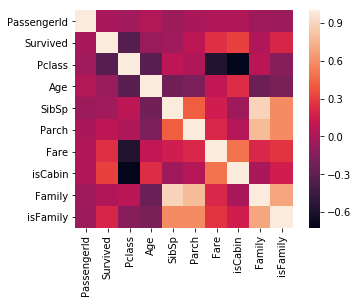

In [22]:
# Final correlation check
sns.heatmap(train_data.corr(), square=True)

# CREATE MODEL

From now on we start to create and fit a model.

In [23]:
# Select prediction target data
y_train = train_data.Survived

# ----------------------------------------------------------------
# Create title feature
def extract_title(name):
    return re.search(r'\w+(?=[.])', name).group(0)
train_data['Title'] = train_data.Name.map(extract_title)
test_data['Title'] = test_data.Name.map(extract_title)

# ----------------------------------------------------------------
# Fill passenger's age as mean age for his/her title group
mean_ages_by_title = train_data.groupby('Title')['Age'].mean()
mean_age = train_data.Age.mean()

def fill_age_by_title(row):
    if pd.isna(row.Age):
        if row.Title in mean_ages_by_title.index:
            row.Age = mean_ages_by_title[row.Title]
        row.Age = mean_age
    return row

train_data = train_data.apply(fill_age_by_title, axis=1)
test_data = test_data.apply(fill_age_by_title, axis=1)

# ----------------------------------------------------------------
# Replace 0 fares with mean by class
mean_fare_by_class = train_data.groupby('Pclass')['Fare'].mean()

def fill_fare_by_class(row):
    if row.Fare == 0 or pd.isna(row.Fare):
        row.Fare = mean_fare_by_class[row.Pclass]
    return row

train_data = train_data.apply(fill_fare_by_class, axis=1)
test_data = test_data.apply(fill_fare_by_class, axis=1)

# ----------------------------------------------------------------
# Create isCabin feature: True if Cabin is not NaN
train_data['isCabin'] = train_data.Cabin.notna().astype('int')
test_data['isCabin'] = test_data.Cabin.notna().astype('int')

# ----------------------------------------------------------------
# Create Family feature: Parch + SibSp
train_data['Family'] = train_data.Parch + train_data.SibSp
test_data['Family'] = test_data.Parch + test_data.SibSp

# ----------------------------------------------------------------
# Create isFamily feature: True if Family is not 0
train_data['isFamily'] = (train_data.Family != 0).astype('int')
test_data['isFamily'] = (test_data.Family != 0).astype('int')

# ----------------------------------------------------------------
# Create isMaleInEconomClass
train_data['isMaleInEconomClass'] = ((train_data.Sex == 'male') & (train_data.Pclass == 3)).astype('int')
test_data['isMaleInEconomClass'] = ((test_data.Sex == 'male') & (test_data.Pclass == 3)).astype('int')

# ----------------------------------------------------------------
# Select features to build model on
feature_columns = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Family', 'isFamily', 'isCabin', 'isMaleInEconomClass']
X_train = train_data[feature_columns].copy()
X_test = test_data[feature_columns].copy()

X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family,isFamily,isCabin,isMaleInEconomClass
0,3,male,22.0,7.2500,S,1,1,0,1
1,1,female,38.0,71.2833,C,1,1,1,0
2,3,female,26.0,7.9250,S,0,0,0,0
3,1,female,35.0,53.1000,S,1,1,1,0
4,3,male,35.0,8.0500,S,0,0,0,1


In [24]:
# ----------------------------------------------------------------
# Inspect missing data
print('X_train\n', X_train.apply(lambda x: x.isna().any(), axis=0))
print('\nX_test\n', X_test.apply(lambda x: x.isna().any(), axis=0))

X_train
 Pclass                 False
Sex                    False
Age                    False
Fare                   False
Embarked               False
Family                 False
isFamily               False
isCabin                False
isMaleInEconomClass    False
dtype: bool

X_test
 Pclass                 False
Sex                    False
Age                    False
Fare                   False
Embarked               False
Family                 False
isFamily               False
isCabin                False
isMaleInEconomClass    False
dtype: bool


In [25]:
# ----------------------------------------------------------------
# Create preprocessor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('sex', OneHotEncoder(dtype='int', sparse=False, drop='first'), ['Sex']),
        ('embarked', OrdinalEncoder(dtype='int'), ['Embarked']),
        ('passthrough', 'passthrough', ['Pclass', 'Age', 'Fare', 'Family', 'isCabin', 'isMaleInEconomClass'])
    ])

In [26]:
# ----------------------------------------------------------------
# Model 1: Random Forest
from sklearn.ensemble import RandomForestClassifier
model_1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
print(model_1)

# ----------------------------------------------------------------
# Cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_1, preprocessor.fit_transform(X_train), y_train, cv=5)

print('Scores:', scores)
print('Mean score:', scores.mean())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Scores: [0.79329609 0.82681564 0.82022472 0.80898876 0.82485876]
Mean score: 0.814836794410358


In [27]:
# ----------------------------------------------------------------
# Model 2: eXtreme Gradient Boosting
from xgboost import XGBClassifier
model_2 = XGBClassifier(n_estimators=500, max_depth=3, learning_rate=0.05)
print(model_2)

# ----------------------------------------------------------------
# Cross-validation
scores = cross_val_score(model_2, preprocessor.fit_transform(X_train), y_train, cv=5)

print('Scores:', scores)
print('Mean score:', scores.mean())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Scores: [0.81564246 0.80446927 0.86516854 0.81460674 0.83050847]
Mean score: 0.8260790974637446


In [28]:
# ----------------------------------------------------------------
# Model 3: Support Vectors
from sklearn.svm import SVC
model_3 = SVC(gamma='auto', random_state=1)
print(model_3)

# Add normalization proceedure for SVC
from sklearn.preprocessing import StandardScaler
normalizator = ColumnTransformer(transformers=[
    ('stdscale', StandardScaler(copy=False, with_mean=True, with_std=True), slice(None, None, 1))
])

preproc2 = Pipeline(verbose=False, steps=[
    ('preprocessor', preprocessor),
    ('normalizator', normalizator)
])

# ----------------------------------------------------------------
# Cross-validation
scores = cross_val_score(model_3, preproc2.fit_transform(X_train), y_train, cv=5)

print('Scores:', scores)
print('Mean score:', scores.mean())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)
Scores: [0.83798883 0.80446927 0.80898876 0.80337079 0.84745763]
Mean score: 0.8204550556478202


In [29]:
# Fit best model: XGB
model = model_2

normalizator = ColumnTransformer(transformers=[
    ('stdscale', StandardScaler(copy=False, with_mean=True, with_std=True), slice(None, None, 1))
])

# Cause best model is not SVC, normalization is not needed
ppline = Pipeline(verbose=True, steps=[
    ('preprocessor', preprocessor),
    #('normalization', normalizator), 
    ('model', model)
])

ppline.fit(X_train, y_train)

# Make predictions
predictions = ppline.predict(X_test)

# Prepare submission
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Submission was successfully saved!")

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.3s
Submission was successfully saved!
